<a href="https://colab.research.google.com/github/seepala98/EVA4-P2/blob/master/session8/Session8_Drones_SRGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sat Oct 10 10:33:34 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    12W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!unzip '/content/gdrive/My Drive/e4p2/dataset_final.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/large_drone/large_drone_1587.jpg  
  inflating: Dataset/large_drone/large_drone_2794.jpg  
  inflating: Dataset/large_drone/large_drone_3790.jpg  
  inflating: Dataset/large_drone/large_drone_1108.jpg  
  inflating: Dataset/large_drone/large_drone_3760.jpg  
  inflating: Dataset/large_drone/large_drone_3369.jpg  
  inflating: Dataset/large_drone/large_drone_3775.jpg  
  inflating: Dataset/large_drone/large_drone_2231.jpg  
  inflating: Dataset/large_drone/large_drone_3755.jpg  
  inflating: Dataset/large_drone/large_drone_642.jpg  
  inflating: Dataset/large_drone/large_drone_321.jpg  
  inflating: Dataset/large_drone/large_drone_3628.jpg  
  inflating: Dataset/large_drone/large_drone_3287.jpg  
  inflating: Dataset/large_drone/large_drone_865.jpg  
  inflating: Dataset/large_drone/large_drone_1261.jpg  
  inflating: Dataset/large_drone/large_drone_1016.jpg  
  inflating: Dataset/large_drone/large_drone_263.jpg  
 

In [4]:
!mkdir data
!mkdir data/train
!mkdir data/val

In [5]:
!mv /content/Dataset/large_drone/* /content/data/train/

In [6]:
!mv /content/data/train/large_drone_97* /content/data/val

In [7]:
!ls -la /content/data/val | wc -l
!ls -la /content/data/train | wc -l

14
3940


In [8]:
  
import argparse
import os
from math import log10

import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.utils as utils
from torch.autograd import Variable
from torch.utils.data import DataLoader
from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from torchsummary import summary

import warnings
warnings.filterwarnings("ignore")

In [9]:
!mkdir statistics
!mkdir chkpt
clear_output()
!ls /content/data/train|wc -l
!ls /content/data/val|wc -l

3937
11


In [10]:
CROP_SIZE = 176  #training images crop size
UPSCALE_FACTOR = 2  #2/4/8
TRAIN_ROOT = '/content/data/train/'
VAL_ROOT = '/content/data/val/'

In [11]:
from os import listdir
from os.path import join

from PIL import Image
from torch.utils.data.dataset import Dataset
from torchvision.transforms import Compose, RandomCrop, ToTensor, ToPILImage, CenterCrop, Resize

In [12]:

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG'])

def calculate_valid_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)


def train_hr_transform(crop_size):
    return Compose([
		#ToPILImage(mode = 'RGB'),
		Resize(crop_size),
        RandomCrop(crop_size),
        ToTensor(),
    ])


def train_lr_transform(crop_size, upscale_factor):
    return Compose([
        ToPILImage(mode = 'RGB'),
		Resize(crop_size),
        Resize(crop_size // upscale_factor, interpolation=Image.BICUBIC),
        ToTensor()
    ])


def display_transform():
    return Compose([
        ToPILImage(mode='RGB'),
        Resize(400),
        CenterCrop(400),
        ToTensor()
    ])

class TrainDatasetFromFolder(Dataset):
    def __init__(self, dataset_dir, crop_size, upscale_factor):
        super(TrainDatasetFromFolder, self).__init__()
        self.image_filenames = [join(dataset_dir, x) for x in listdir(dataset_dir) if is_image_file(x)]
        crop_size = calculate_valid_crop_size(crop_size, upscale_factor)
        self.hr_transform = train_hr_transform(crop_size)
        self.lr_transform = train_lr_transform(crop_size, upscale_factor)

    def __getitem__(self, index):
        hr_image = self.hr_transform(Image.open(self.image_filenames[index]).convert('RGB'))
        lr_image = self.lr_transform(hr_image)
        return lr_image, hr_image

    def __len__(self):
        return len(self.image_filenames)


class ValDatasetFromFolder(Dataset):
    def __init__(self, dataset_dir, upscale_factor):
        super(ValDatasetFromFolder, self).__init__()
        self.upscale_factor = upscale_factor
        self.image_filenames = [join(dataset_dir, x) for x in listdir(dataset_dir) if is_image_file(x)]

    def __getitem__(self, index):
        hr_image = Image.open(self.image_filenames[index]).convert('RGB')
        w, h = hr_image.size
        crop_size = calculate_valid_crop_size(min(w, h), self.upscale_factor)
        lr_scale = Resize(crop_size // self.upscale_factor, interpolation=Image.BICUBIC)
        hr_scale = Resize(crop_size, interpolation=Image.BICUBIC)
        hr_image = CenterCrop(crop_size)(hr_image)
        lr_image = lr_scale(hr_image)
        hr_restore_img = hr_scale(lr_image)
        return ToTensor()(lr_image), ToTensor()(hr_restore_img), ToTensor()(hr_image)

    def __len__(self):
        return len(self.image_filenames)


In [13]:
train_set = TrainDatasetFromFolder(TRAIN_ROOT, crop_size=CROP_SIZE, upscale_factor=UPSCALE_FACTOR)
val_set = ValDatasetFromFolder(VAL_ROOT, upscale_factor=UPSCALE_FACTOR)
train_loader = DataLoader(dataset=train_set, num_workers=2, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_set, num_workers=2, batch_size=1, shuffle=False)

# Decide which device we want to run on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


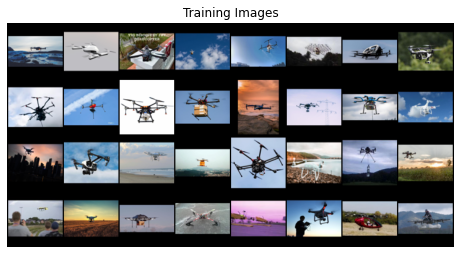

In [14]:
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [15]:
import math

class Generator(nn.Module):
    def __init__(self, scale_factor):
        upsample_block_num = int(math.log(scale_factor, 2))

        super(Generator, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),
            nn.ReLU()
        )
        self.block2 = ResidualBlock(64)
        self.block3 = ResidualBlock(64)
        self.block4 = ResidualBlock(64)
        self.block5 = ResidualBlock(64)
        self.block6 = ResidualBlock(64)
        self.block7 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
        )
        block8 = [UpsampleBLock(64, 2) for _ in range(upsample_block_num)]
        block8.append(nn.Conv2d(64, 3, kernel_size=9, padding=4))
        self.block8 = nn.Sequential(*block8)

    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)
        block6 = self.block6(block5)
        block7 = self.block7(block6)
        block8 = self.block8(block1 + block7)

        return (torch.tanh(block8) + 1) / 2


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(512, 1024, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(1024, 1, kernel_size=1)
        )

    def forward(self, x):
        batch_size = x.size(0)
        return torch.sigmoid(self.net(x).view(batch_size))


class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.relu(residual)
        residual = self.conv2(residual)
        residual = self.bn2(residual)

        return x + residual


class UpsampleBLock(nn.Module):
    def __init__(self, in_channels, up_scale):
        super(UpsampleBLock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * up_scale ** 2, kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(up_scale)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.relu(x)
        return x

In [16]:
netG = Generator(UPSCALE_FACTOR).to(device)
print('# generator parameters:', sum(param.numel() for param in netG.parameters()))
netD = Discriminator().to(device)
print('# discriminator parameters:', sum(param.numel() for param in netD.parameters()))

# generator parameters: 586499
# discriminator parameters: 5215425


In [17]:
summary(netG, input_size=(3,44,44))
summary(netD, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 44, 44]          15,616
              ReLU-2           [-1, 64, 44, 44]               0
            Conv2d-3           [-1, 64, 44, 44]          36,928
       BatchNorm2d-4           [-1, 64, 44, 44]             128
              ReLU-5           [-1, 64, 44, 44]               0
            Conv2d-6           [-1, 64, 44, 44]          36,928
       BatchNorm2d-7           [-1, 64, 44, 44]             128
     ResidualBlock-8           [-1, 64, 44, 44]               0
            Conv2d-9           [-1, 64, 44, 44]          36,928
      BatchNorm2d-10           [-1, 64, 44, 44]             128
             ReLU-11           [-1, 64, 44, 44]               0
           Conv2d-12           [-1, 64, 44, 44]          36,928
      BatchNorm2d-13           [-1, 64, 44, 44]             128
    ResidualBlock-14           [-1, 64,

In [18]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [19]:
import torch
from torch import nn
from torchvision.models.vgg import vgg16


class GeneratorLoss(nn.Module):
    def __init__(self):
        super(GeneratorLoss, self).__init__()
        vgg = vgg16(pretrained=True)
        loss_network = nn.Sequential(*list(vgg.features)[:31]).eval()
        for param in loss_network.parameters():
            param.requires_grad = False
        self.loss_network = loss_network
        self.mse_loss = nn.MSELoss()
        self.tv_loss = TVLoss()

    def forward(self, out_labels, out_images, target_images):
        # Adversarial Loss
        adversarial_loss = torch.mean(1 - out_labels)
        # Perception Loss
        perception_loss = self.mse_loss(self.loss_network(out_images), self.loss_network(target_images))
        # Image Loss
        image_loss = self.mse_loss(out_images, target_images)
        # TV Loss
        tv_loss = self.tv_loss(out_images)
        return image_loss + 0.001 * adversarial_loss + 0.006 * perception_loss + 2e-8 * tv_loss


class TVLoss(nn.Module):
    def __init__(self, tv_loss_weight=1):
        super(TVLoss, self).__init__()
        self.tv_loss_weight = tv_loss_weight

    def forward(self, x):
        batch_size = x.size()[0]
        h_x = x.size()[2]
        w_x = x.size()[3]
        count_h = self.tensor_size(x[:, :, 1:, :])
        count_w = self.tensor_size(x[:, :, :, 1:])
        h_tv = torch.pow((x[:, :, 1:, :] - x[:, :, :h_x - 1, :]), 2).sum()
        w_tv = torch.pow((x[:, :, :, 1:] - x[:, :, :, :w_x - 1]), 2).sum()
        return self.tv_loss_weight * 2 * (h_tv / count_h + w_tv / count_w) / batch_size

    @staticmethod
    def tensor_size(t):
        return t.size()[1] * t.size()[2] * t.size()[3]


if __name__ == "__main__":
    g_loss = GeneratorLoss()
    print(g_loss)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



GeneratorLoss(
  (loss_network): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, paddin

In [20]:
# Initialize BCELoss function
generator_criterion = GeneratorLoss().to(device)
netD.apply(weights_init)
netG.apply(weights_init)
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
results = {'d_loss': [], 'g_loss': [], 'd_score': [], 'g_score': [], 'psnr': [], 'ssim': []}


# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters()) # , lr=lr, betas=(beta1, 0.999)
optimizerG = optim.Adam(netG.parameters())

In [21]:
from math import exp

import torch
import torch.nn.functional as F
from torch.autograd import Variable


def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size // 2) ** 2 / float(2 * sigma ** 2)) for x in range(window_size)])
    return gauss / gauss.sum()


def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window


def _ssim(img1, img2, window, window_size, channel, size_average=True):
    mu1 = F.conv2d(img1, window, padding=window_size // 2, groups=channel)
    mu2 = F.conv2d(img2, window, padding=window_size // 2, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size // 2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size // 2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=window_size // 2, groups=channel) - mu1_mu2

    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)


class SSIM(torch.nn.Module):
    def __init__(self, window_size=11, size_average=True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)

            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)

            self.window = window
            self.channel = channel

        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)


def ssim(img1, img2, window_size=11, size_average=True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)

    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)

    return _ssim(img1, img2, window, window_size, channel, size_average)

In [22]:
# Training Loop
START_EPOCH = 1
NUM_EPOCHS  = 20
print("Starting Training Loop...")
# For each epoch
for epoch in range(START_EPOCH, NUM_EPOCHS+START_EPOCH+1):
    # For each batch in the dataloader    
    train_bar = tqdm(train_loader)
    running_results = {'batch_sizes': 0, 'd_loss': 0, 'g_loss': 0, 'd_score': 0, 'g_score': 0}

    netG.train()
    netD.train()
    for data, target in train_bar:
        g_update_first = True
        batch_size = data.size(0)
        running_results['batch_sizes'] += batch_size

        ############################
        # (1) Update D network: maximize D(x)-1-D(G(z))
        ###########################
        real_img = Variable(target)
        if torch.cuda.is_available():
            real_img = real_img.cuda()
        z = Variable(data)
        if torch.cuda.is_available():
            z = z.cuda()
        fake_img = netG(z)

        netD.zero_grad()
        real_out = netD(real_img).mean()
        fake_out = netD(fake_img).mean()
        d_loss = 1 - real_out + fake_out
        d_loss.backward(retain_graph=True)
        optimizerD.step()

        ############################
        # (2) Update G network: minimize 1-D(G(z)) + Perception Loss + Image Loss + TV Loss
        ###########################
        netG.zero_grad()
        ############################################################
        ## The two lines below are added to prevent runetime error! ##
        fake_img = netG(z)
        fake_out = netD(fake_img).mean()
        ############################################################
        g_loss = generator_criterion(fake_out, fake_img, real_img)
        g_loss.backward()
        
        # fake_img = netG(z)
        # fake_out = netD(fake_img).mean()
        
        
        optimizerG.step()

        # loss for current batch before optimization 
        running_results['g_loss'] += g_loss.item() * batch_size
        running_results['d_loss'] += d_loss.item() * batch_size
        running_results['d_score'] += real_out.item() * batch_size
        running_results['g_score'] += fake_out.item() * batch_size

        train_bar.set_description(desc='[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f' % (
            epoch, NUM_EPOCHS, running_results['d_loss'] / running_results['batch_sizes'],
            running_results['g_loss'] / running_results['batch_sizes'],
            running_results['d_score'] / running_results['batch_sizes'],
            running_results['g_score'] / running_results['batch_sizes']))

    netG.eval()
    out_path = 'training_results/SRF_' + str(UPSCALE_FACTOR) + '/'
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    
    with torch.no_grad():
        val_bar = tqdm(val_loader)
        valing_results = {'mse': 0, 'ssims': 0, 'psnr': 0, 'ssim': 0, 'batch_sizes': 0}
        val_images = []
        index = 0
        for val_lr, val_hr_restore, val_hr in val_bar:
            index += 1
            batch_size = val_lr.size(0)
            valing_results['batch_sizes'] += batch_size
            lr = val_lr
            hr = val_hr
            if torch.cuda.is_available():
                lr = lr.cuda()
                hr = hr.cuda()
            sr = netG(lr)
    
            batch_mse = ((sr - hr) ** 2).data.mean()
            valing_results['mse'] += batch_mse * batch_size
            batch_ssim = ssim(sr, hr).item()
            valing_results['ssims'] += batch_ssim * batch_size
            valing_results['psnr'] = 10 * log10((hr.max()**2) / (valing_results['mse'] / valing_results['batch_sizes']))
            valing_results['ssim'] = valing_results['ssims'] / valing_results['batch_sizes']
            val_bar.set_description(
                desc='[converting LR images to SR images] PSNR: %.4f dB SSIM: %.4f' % (
                    valing_results['psnr'], valing_results['ssim']))

            val_images.extend(
                [display_transform()(val_hr_restore.squeeze(0)), display_transform()(hr.data.cpu().squeeze(0)),
                    display_transform()(sr.data.cpu().squeeze(0))])
        val_images = torch.stack(val_images)
        val_images = torch.chunk(val_images, val_images.size(0) // 15)
        val_save_bar = tqdm(val_images, desc='[saving training results]')
        index = 1
        for image in val_save_bar:
            image = utils.make_grid(image, nrow=3, padding=5)
            utils.save_image(image, out_path + 'UF4_epoch_%d_index_%d.png' % (epoch, index), padding=5)
            index += 1

    # save model parameters
    # save loss\scores\psnr\ssim
    results['d_loss'].append(running_results['d_loss'] / running_results['batch_sizes'])
    results['g_loss'].append(running_results['g_loss'] / running_results['batch_sizes'])
    results['d_score'].append(running_results['d_score'] / running_results['batch_sizes'])
    results['g_score'].append(running_results['g_score'] / running_results['batch_sizes'])
    results['psnr'].append(valing_results['psnr'])
    results['ssim'].append(valing_results['ssim'])

    if epoch % 10 == 0 or epoch == 1 or epoch == NUM_EPOCHS:
        torch.save(netG.state_dict(), 'chkpt/netG_epoch_%d_%d.pth' % (UPSCALE_FACTOR, epoch))
        torch.save(netD.state_dict(), 'chkpt/netD_epoch_%d_%d.pth' % (UPSCALE_FACTOR, epoch))
        out_path = 'statistics/'
        data_frame = pd.DataFrame(
            data={'Loss_D': results['d_loss'], 'Loss_G': results['g_loss'], 'Score_D': results['d_score'],
                    'Score_G': results['g_score'], 'PSNR': results['psnr'], 'SSIM': results['ssim']},
            index=range(1, epoch + 1))
        data_frame.to_csv(out_path + 'srf_' + str(UPSCALE_FACTOR) + '_train_results.csv', index_label='Epoch')

  0%|          | 0/124 [00:00<?, ?it/s]

Starting Training Loop...


[1/40] Loss_D: 0.8687 Loss_G: 0.0159 D(x): 0.6481 D(G(z)): 0.5055: 100%|██████████| 124/124 [05:12<00:00,  2.52s/it]
[converting LR images to SR images] PSNR: 19.0629 dB SSIM: 0.8489: 100%|██████████| 11/11 [00:02<00:00,  4.53it/s]
[saving training results]: 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]
[2/40] Loss_D: 1.0006 Loss_G: 0.0069 D(x): 0.7188 D(G(z)): 0.7151: 100%|██████████| 124/124 [05:12<00:00,  2.52s/it]
[converting LR images to SR images] PSNR: 25.9182 dB SSIM: 0.8979: 100%|██████████| 11/11 [00:02<00:00,  4.55it/s]
[saving training results]: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]
[3/40] Loss_D: 1.0028 Loss_G: 0.0049 D(x): 0.8743 D(G(z)): 0.8788: 100%|██████████| 124/124 [05:12<00:00,  2.52s/it]
[converting LR images to SR images] PSNR: 20.7030 dB SSIM: 0.7333: 100%|██████████| 11/11 [00:02<00:00,  4.57it/s]
[saving training results]: 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]
[4/40] Loss_D: 1.0000 Loss_G: 0.0042 D(x): 1.0000 D(G(z)): 1.0000: 100%|██████████| 1

In [23]:
SV_LOC = 'DCGAN_cars.pt'
save_jit(netG,SV_LOC)

NameError: ignored

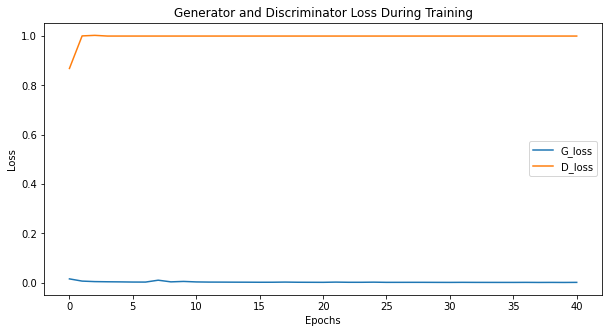

In [25]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(results['g_loss'],label="G_loss")
plt.plot(results['d_loss'],label="D_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

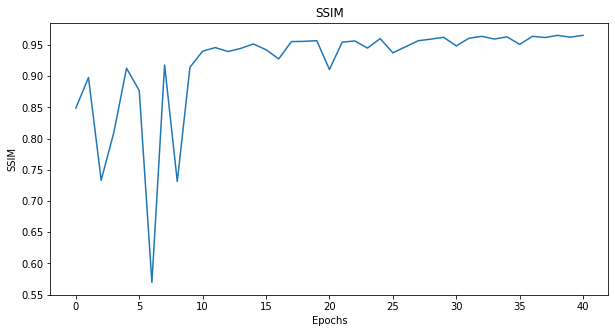

In [26]:
plt.figure(figsize=(10,5))
plt.title("SSIM")
plt.plot(results['ssim'],label="G_loss")
plt.xlabel("Epochs")
plt.ylabel("SSIM")
plt.show()

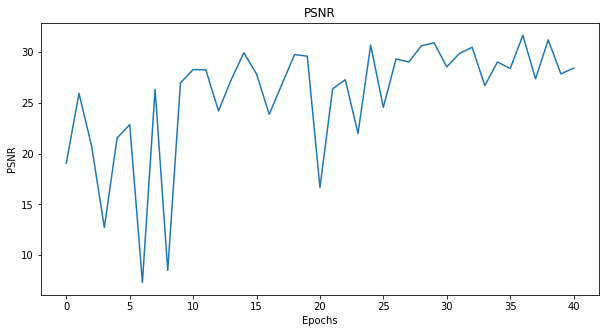

In [27]:
plt.figure(figsize=(10,5))
plt.title("PSNR")
plt.plot(results['psnr'],label="G_loss")
plt.xlabel("Epochs")
plt.ylabel("PSNR")
plt.show()

In [28]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
torch.save(netD, 'SRGAN_Drone_NetD.pth')
torch.save(netG, 'SRGAN_Drone_NetG.pth')

Mounted at /content/gdrive


In [31]:
!cp /content/SRGAN_Drone_NetG.pth '/content/gdrive/My Drive/eva-4/Phase-2/Session-8/'

In [36]:
###  convert model to Onnx runtime

x = torch.randn(1, 3, 400, 400, requires_grad=True).to(device)
torch_out = netG(x)

batch_size = 1
torch.onnx.export(netG,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "SRGAN_Drone_NetG.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes
                                'output' : {0 : 'batch_size'}},
                  example_outputs = torch.randn(1,3,256,256))


torch_out1 = netD(x)
torch.onnx.export(netD,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "SRGAN_Drone_NetD.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes
                                'output' : {0 : 'batch_size'}},
                  example_outputs = torch.randn(1,1,1,1))

!cp SRGAN_Drone* '/content/gdrive/My Drive/eva-4/Phase-2/Session-8/models'

In [35]:
!zip Uf4_176.zip /content/training_results/SRF_4/*

	zip warning: name not matched: /content/training_results/SRF_4/*

zip error: Nothing to do! (Uf4_176.zip)


In [37]:
!pip install onnx onnxruntime

     |████████████████████████████████| 7.4MB 3.7MB/s 
     |████████████████████████████████| 3.8MB 46.8MB/s 


In [38]:
import onnx

onnx_model = onnx.load("/content/SRGAN_Drone_NetG.onnx")
onnx.checker.check_model(onnx_model)



In [39]:
def denorm_numpy(x):
    x_norm = (x - x.min()) / (x.max() - x.min())
    return x_norm

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

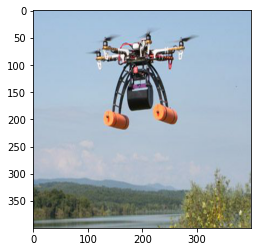

In [49]:
from PIL import Image
im = Image.open("/content/0a087b435426b21faae160de97713ef4.jpg").resize((400,400))
im

np_im_in = np.array(im).astype(np.float32)/255
plt.imshow(np_im_in)
np_im = np.moveaxis(np_im_in, 2 ,0)
np_im = np.expand_dims(np_im, 0)


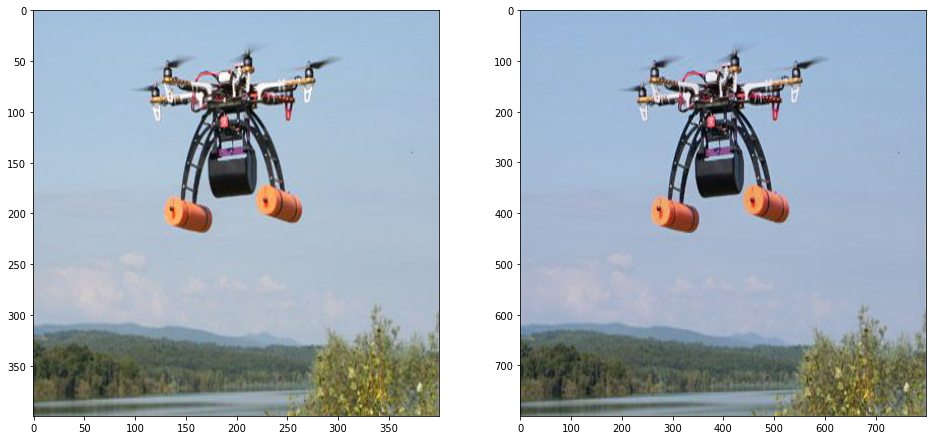

In [50]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("SRGAN_Drone_NetG.onnx")
ort_inputs = {ort_session.get_inputs()[0].name: np_im}
ort_outs = ort_session.run(None, ort_inputs)[0]

#out = denorm_numpy(ort_outs[0])
out = np.moveaxis(ort_outs[0], 0, 2)
plt.figure(figsize=(16, 20))
plt.subplot(1, 2, 1)
plt.imshow(np_im_in)
plt.subplot(1, 2, 2)
plt.imshow(out)


In [51]:
from torchvision.transforms import Compose, RandomCrop, ToTensor, ToPILImage, CenterCrop, Resize
from PIL import Image
im = Image.open("/content/0a087b435426b21faae160de97713ef4.jpg").convert('RGB')

def display_transform():
    return Compose([
        Resize(400),
        CenterCrop(400),
        ToTensor()
    ])

im_t = display_transform()(im).unsqueeze(0).to(device)
im_t.shape
out_t = netG(im_t)

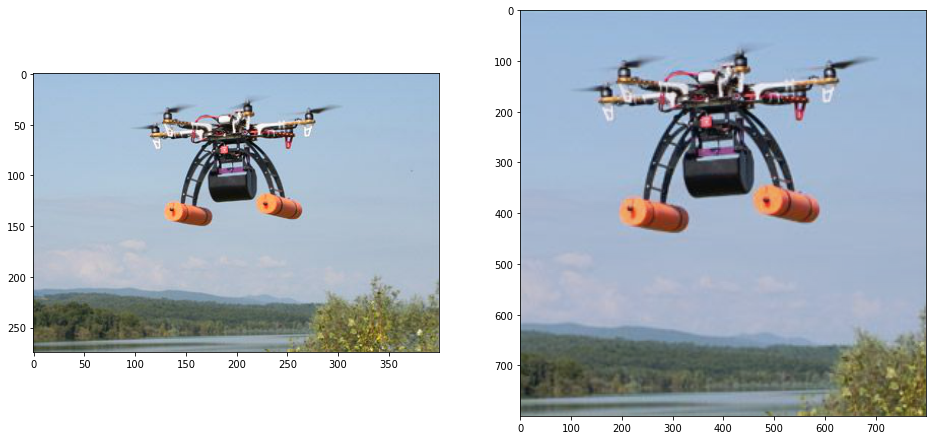

In [52]:
out_np = out_t.squeeze().detach().cpu().numpy()
out = np.moveaxis(out_np, 0, 2)

plt.figure(figsize=(16, 20))
plt.subplot(1, 2, 1)
plt.imshow(np.array(im).astype(np.float32)/255)
plt.subplot(1, 2, 2)
plt.imshow(out)